For refrence: https://www.kaggle.com/vetrirah/customer

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from potosnail import *

ml = MachineLearning()
dh = DataHelper()

def Binarize(df, columns_list):
    for col in columns_list:
        booly = list(df[col].apply(lambda x: x==df[col][0], False))
        inty = list(map(int, booly))
        df[col] = inty
    return df

def OHE(series):
    ohe = OneHotEncoder()
    oh = pd.DataFrame(ohe.fit_transform(np.array(series).reshape(-1, 1)).toarray())
    oh.columns = list(np.unique(series))
    return oh

In [2]:
df0 = pd.read_csv('https://raw.githubusercontent.com/spe301/Clustering-Automobile-Customers/main/Train.csv')

In [3]:
df = df0.drop(['ID', 'Var_1', 'Segmentation'], axis='columns')
df

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,Male,No,22,No,Healthcare,1.0,Low,4.0
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0
...,...,...,...,...,...,...,...,...
8063,Male,No,22,No,NaN,0.0,Low,7.0
8064,Male,No,35,No,Executive,3.0,Low,4.0
8065,Female,No,33,Yes,Healthcare,1.0,Low,1.0
8066,Female,No,27,Yes,Healthcare,1.0,Low,4.0


How I'm going to go about this...

1. get the dataset ready for modeling
2. run a baseline clustering model
3. split the dataframe into multiple dataframes and convert with pd.to_sql() to stimulate a database, in order to brush up on sql
4. Perform EDA
5. Build a better clustering model and save it

# Making gender, martial status, and graduated binary 

In [4]:
lst = ['Gender', 'Ever_Married', 'Graduated']
Binarize(df, lst)

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,1,1,22,1,Healthcare,1.0,Low,4.0
1,0,0,38,0,Engineer,NaN,Average,3.0
2,0,0,67,0,Engineer,1.0,Low,1.0
3,1,0,67,0,Lawyer,0.0,High,2.0
4,0,0,40,0,Entertainment,NaN,High,6.0
...,...,...,...,...,...,...,...,...
8063,1,1,22,1,NaN,0.0,Low,7.0
8064,1,1,35,1,Executive,3.0,Low,4.0
8065,0,1,33,0,Healthcare,1.0,Low,1.0
8066,0,1,27,0,Healthcare,1.0,Low,4.0


# Filling in NaN values

In [5]:
df['Profession'] = df['Profession'].fillna('None')

In [6]:
df['Work_Experience'] = df['Work_Experience'].fillna(round(np.mean(df['Work_Experience'])))
df['Family_Size'] = df['Family_Size'].fillna(round(np.mean(df['Family_Size'])))

In [7]:
round(np.mean(df['Work_Experience']))

3

In [8]:
df

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size
0,1,1,22,1,Healthcare,1.0,Low,4.0
1,0,0,38,0,Engineer,3.0,Average,3.0
2,0,0,67,0,Engineer,1.0,Low,1.0
3,1,0,67,0,Lawyer,0.0,High,2.0
4,0,0,40,0,Entertainment,3.0,High,6.0
...,...,...,...,...,...,...,...,...
8063,1,1,22,1,None,0.0,Low,7.0
8064,1,1,35,1,Executive,3.0,Low,4.0
8065,0,1,33,0,Healthcare,1.0,Low,1.0
8066,0,1,27,0,Healthcare,1.0,Low,4.0


In [9]:
np.unique(df['Family_Size'])

array([1., 2., 3., 4., 5., 6., 7., 8., 9.])

# Ranking Spending_Score numerically

In [10]:
df['Spending_Score']

0           Low
1       Average
2           Low
3          High
4          High
         ...   
8063        Low
8064        Low
8065        Low
8066        Low
8067    Average
Name: Spending_Score, Length: 8068, dtype: object

In [11]:
ss = df['Spending_Score']
scores = []
for i in range(len(ss)):
    if ss[i] == 'Low':
        scores.append(1)
    if ss[i] == 'Average':
        scores.append(2)
    if ss[i] == 'High':
        scores.append(3)
        
df['Spending_Score'] = scores

# One Hot Encoding profession

In [12]:
professions = OHE(df['Profession'])
df2 = pd.concat([df.drop(['Profession'], axis='columns'), professions], axis='columns')

# Our first clustering model

In [13]:
df2

,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,None
0,1,1,22,1,1.0,1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0,0,38,0,3.0,2,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,67,0,1.0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,0,67,0,0.0,3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,0,40,0,3.0,3,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,1,1,22,1,0.0,1,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8064,1,1,35,1,3.0,1,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8065,0,1,33,0,1.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8066,0,1,27,0,1.0,1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


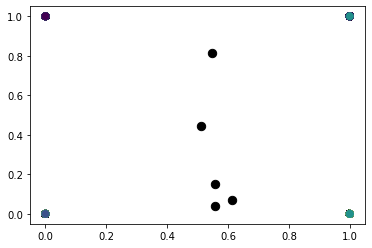

,Gender,Ever_Married,Age,Graduated,Work_Experience,Spending_Score,Family_Size,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing,None,cluster
0,1,1,22,1,1.0,1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1,0,0,38,0,3.0,2,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,0,0,67,0,1.0,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,1,0,67,0,0.0,3,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4
4,0,0,40,0,3.0,3,6.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,1,1,22,1,0.0,1,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
8064,1,1,35,1,3.0,1,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
8065,0,1,33,0,1.0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
8066,0,1,27,0,1.0,1,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


In [31]:
# we use _ clusters because we are segmenting the market into _ categories

def ClusterIt(data, clusters):
    k = KMeans(n_clusters=clusters).fit(data)
    pred = k.predict(df2)
    centers = k.cluster_centers_
    X2 = pd.DataFrame(data)
    y = pd.DataFrame(pred)
    y.columns = ['cluster']
    results = pd.concat([X2, y], axis='columns')
    plt.scatter(np.array(data)[:, 0], np.array(data)[:, 1], c=pred, s=50, cmap='viridis');
    plt.scatter(centers[:, 0], centers[:, 1], s=70, c='black');
    plt.show()
    return results
    
ClusterIt(df2, 5)

In [52]:
dh.ScaleData()

TypeError: ScaleData() missing 2 required positional arguments: 'strategy' and 'X'